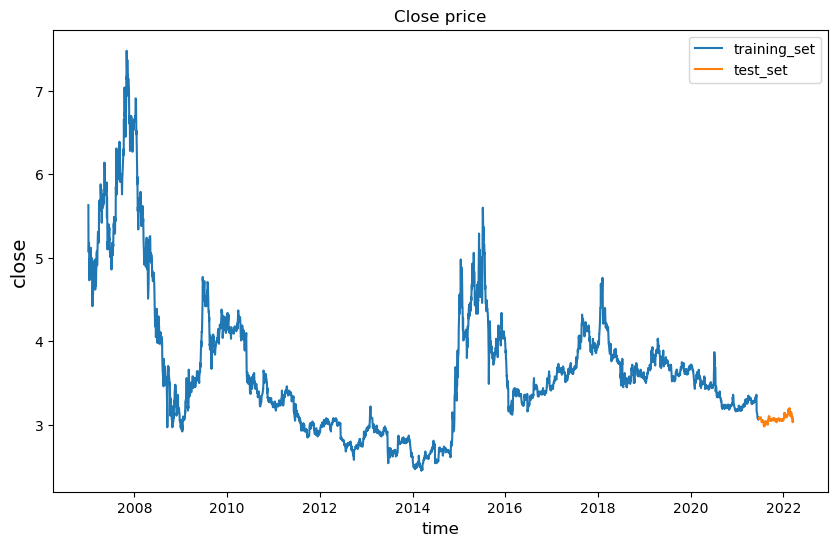

C:\Users\pgpau\AppData\Local\Temp\ipykernel_25192\1627717998.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff(1)


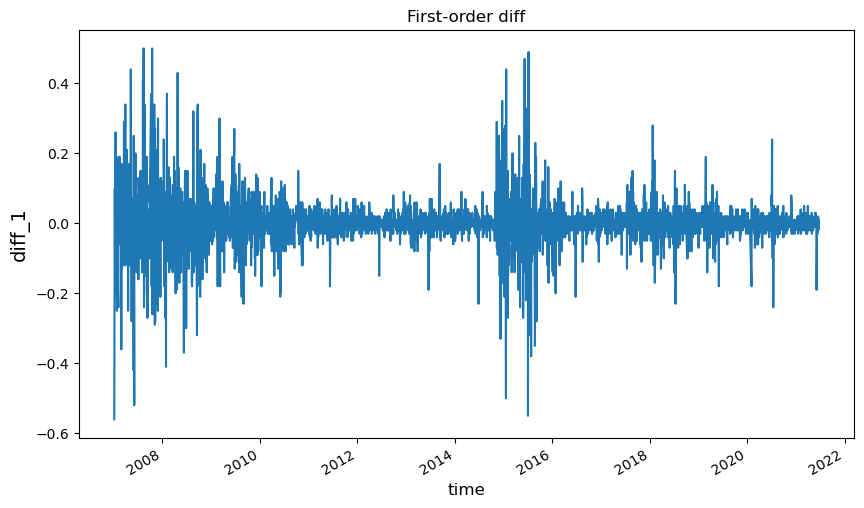

C:\Users\pgpau\AppData\Local\Temp\ipykernel_25192\1627717998.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


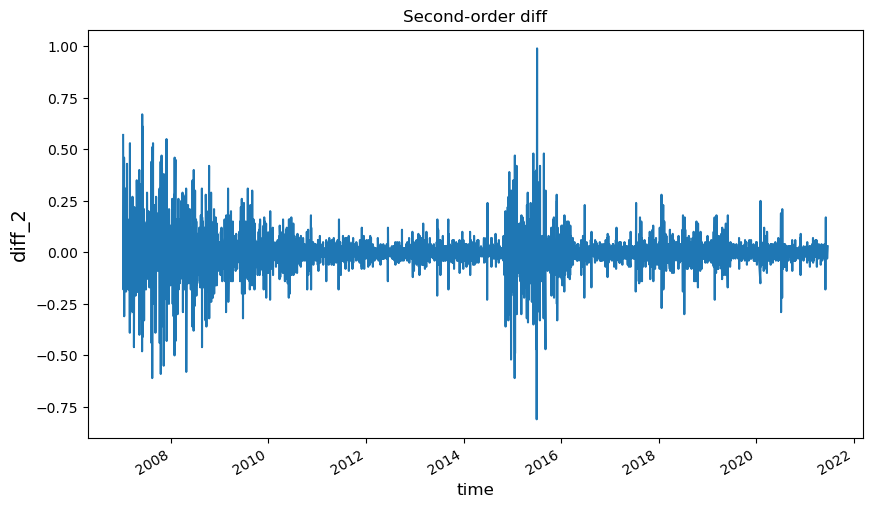

     lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   3.458346   0.062933   3.455383   0.063046
2  23.695323   0.000007  23.669246   0.000007


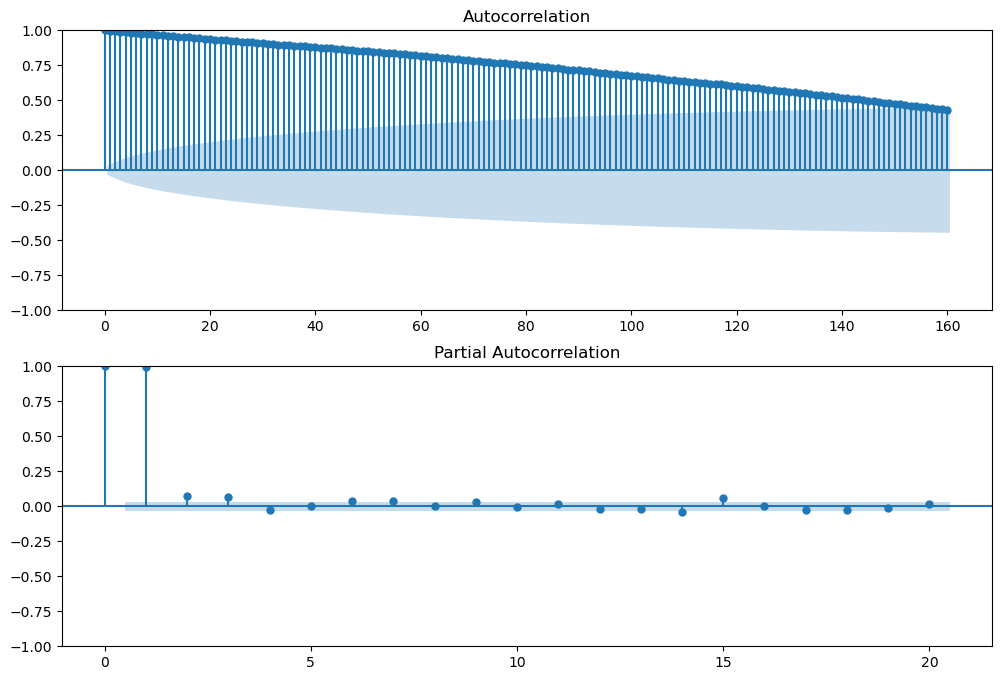

&             close
trade_date       
2007-01-05  -0.56
2007-01-08   0.01
2007-01-09   0.10
2007-01-10  -0.08
2007-01-11  -0.17
...           ...
2021-06-15  -0.01
2021-06-16   0.02
2021-06-17  -0.01
2021-06-18  -0.02
2021-06-21   0.01

[3500 rows x 1 columns]


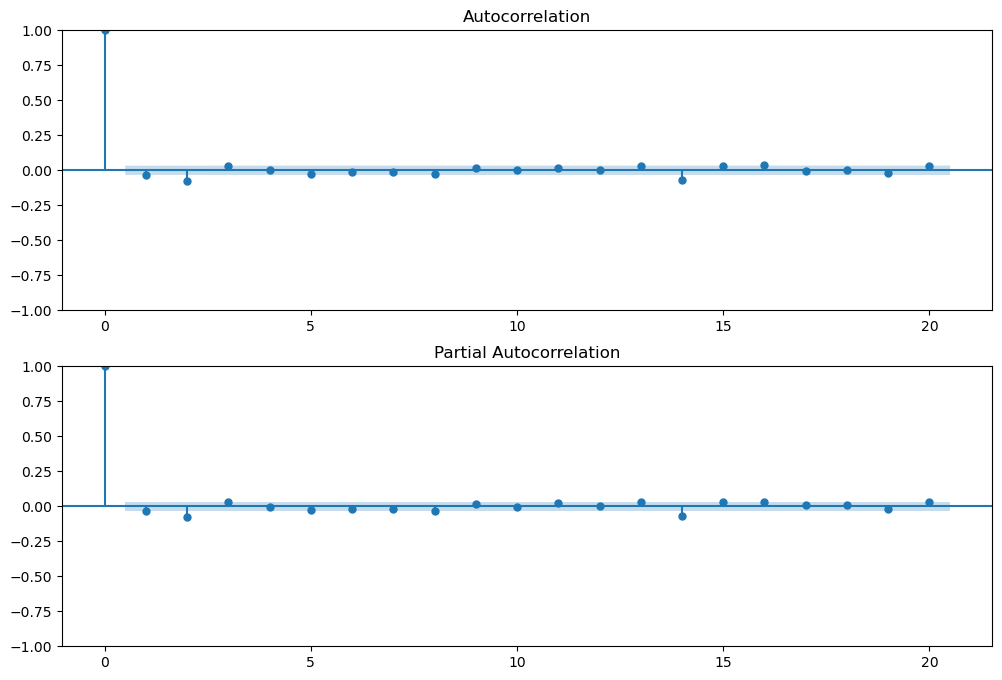

C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgpau\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics
from utils import *
#plt.rcParams['font.sans-serif'] = ['SimHei']    # for chinese text on plt
#plt.rcParams['axes.unicode_minus'] = False      # for chinese text negative symbol '-' on plt

data = pd.read_csv('601988.SH.csv')
test_set2 = data.loc[3501:, :] 
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d') 
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

training_set = data.loc['2007-01-04':'2021-06-21', :]  # 3501
test_set = data.loc['2021-06-22':, :]  # 180

plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='training_set')
plt.plot(test_set['close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

temp = np.array(training_set['close'])

# First-order diff
training_set['diff_1'] = training_set['close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()

# Second-order diff
training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

temp1 = np.diff(training_set['close'], n=1)

# white noise test
training_data1 = training_set['close'].diff(1)
# training_data1_nona = training_data1.dropna()
temp2 = np.diff(training_set['close'], n=1)
# print(acorr_ljungbox(training_data1_nona, lags=2, boxpierce=True, return_df=True))
print(acorr_ljungbox(temp2, lags=2, boxpierce=True))
# p-value=1.53291527e-08, non-white noise time-seriess

acf_pacf_plot(training_set['close'],acf_lags=160)

price = list(temp2)
data2 = {
    'trade_date': training_set['diff_1'].index[1:], 
    'close': price
}

df = pd.DataFrame(data2)
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')

training_data_diff = df.set_index(['trade_date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)

# order=(p,d,q)
model = sm.tsa.ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()
#print(model.summary())

history = [x for x in training_set['close']]
# print('history', type(history), history)
predictions = list()
# print('test_set.shape', test_set.shape[0])
for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float(yhat[0])
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]
    # obs = np.float(obs)
    # print('obs', type(obs))
    history.append(obs)
    # print(test_set.index[t])
    # print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
#print('predictions', predictions)

predictions1 = {
    'trade_date': test_set.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['trade_date'], drop=True)
predictions1.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

model2 = sm.tsa.ARIMA(endog=data['close'], order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')
evaluation_metric(test_set['close'],predictions)
adf_test(temp)
adf_test(temp1)

predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3479:]
print('#', predictions_ARIMA_diff)
plt.figure(figsize=(10, 6))
plt.plot(training_data_diff, label="diff_1")
plt.plot(predictions_ARIMA_diff, label="prediction_diff_1")
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.title('DiffFit')
plt.legend()
plt.show()